**<H1>Implementing a GPT model from scratch to generate text</H1>**

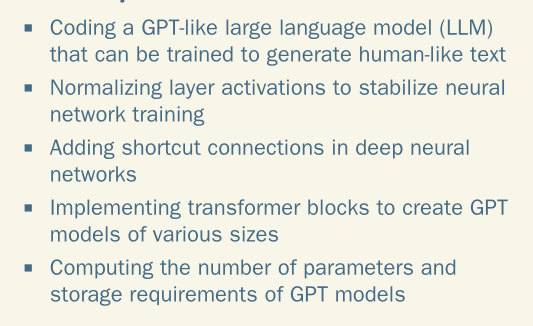

In [ ]:
#specifying small GPT-2 model

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


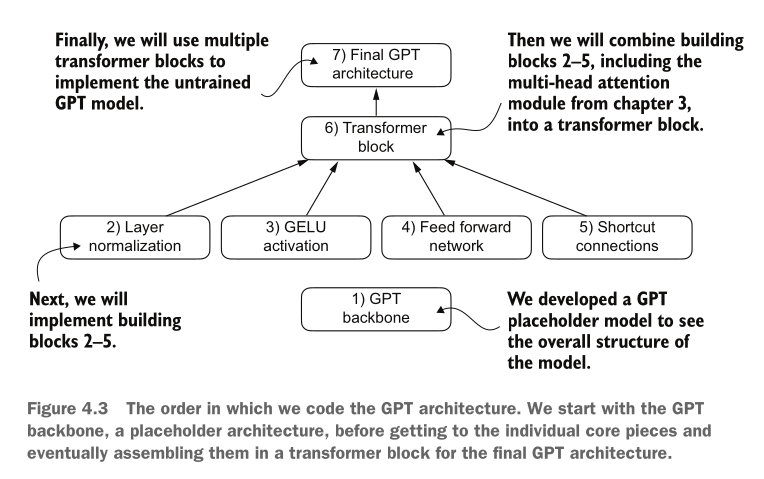

In [ ]:
#placeholder dummy GPT architecture

import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb  = nn.Embedding(cfg['vocab_size'], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg)
          for _ in range (cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module): #simple placeholder will be replaced by real transformer block later
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module): #will be replaced by layer normalization later
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x


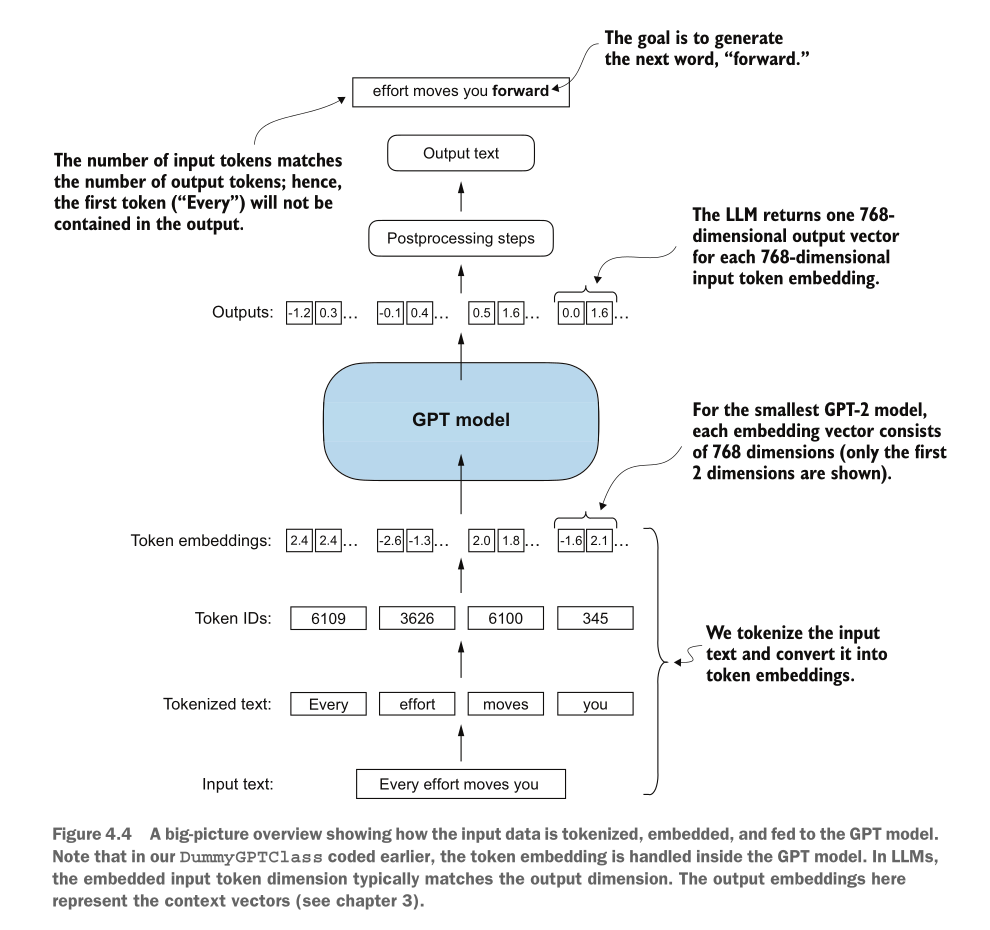

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moved you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 3888,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
#initialize 124 million parameter DummyGPTModel

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Ouput shape: ", logits.shape)
print(logits)

Ouput shape:  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [-0.0059,  0.4590, -0.7278,  ...,  1.3993,  0.4552,  0.1443],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


**<h1> Normalizing activations with layer normalization</h1>**

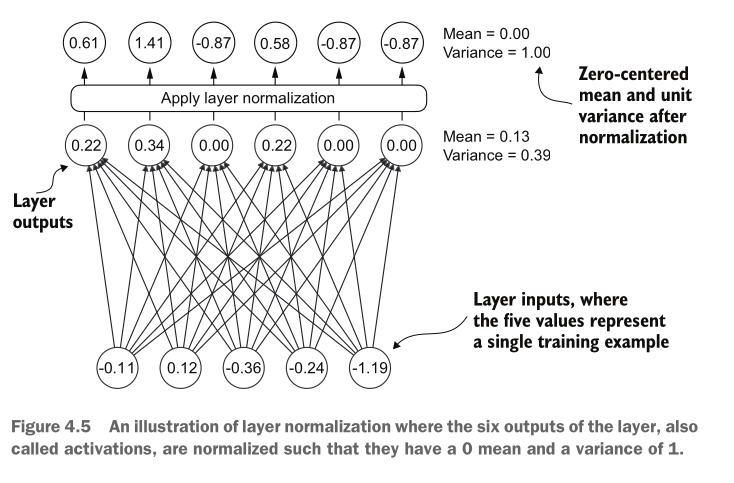

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
print(batch_example)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
print(layer)
out = layer(batch_example)
print(out)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
Sequential(
  (0): Linear(in_features=5, out_features=6, bias=True)
  (1): ReLU()
)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
#before layer normalization

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean: ", mean)
print("var: ",  var)

Mean:  tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var:  tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


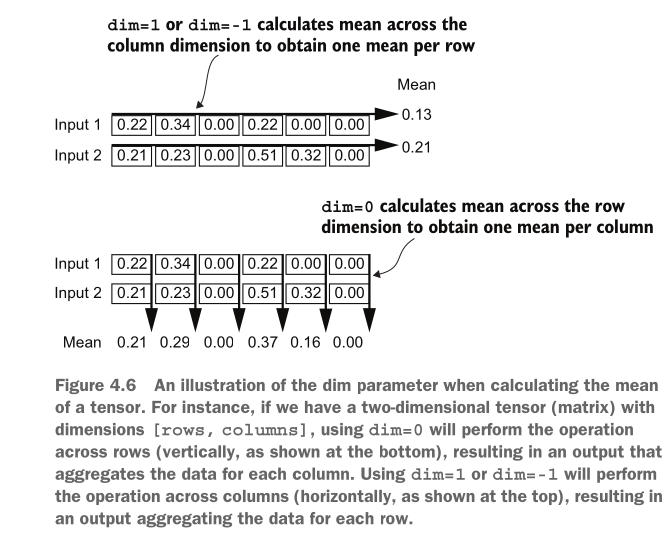

In [ ]:
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean: ", mean)
print("Var: ", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:  tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Var:  tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean) / torch.sqrt(var+self.eps)
    return self.scale * norm_x + self.shift

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**<h1>Implementing a feed forward network with GeLU activation</h1>**
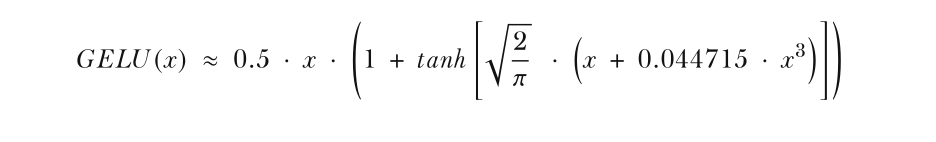

In [ ]:
#implementation of GELU activation function

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
     ))


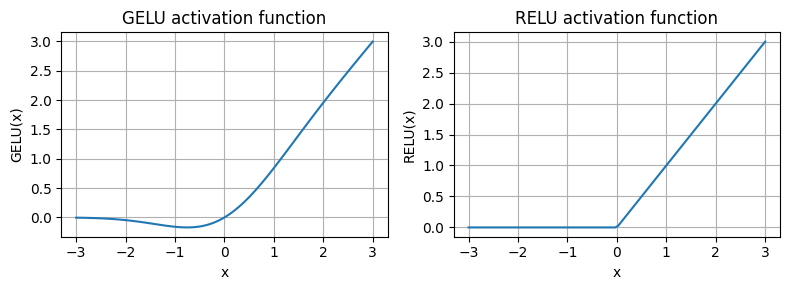

In [ ]:
#comparing ReLU and GELU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )


  def forward(self, x):
    return self.layers(x)

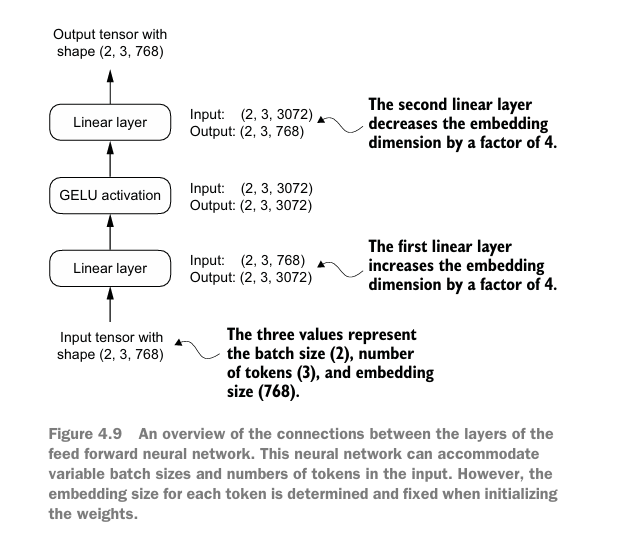

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out=ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


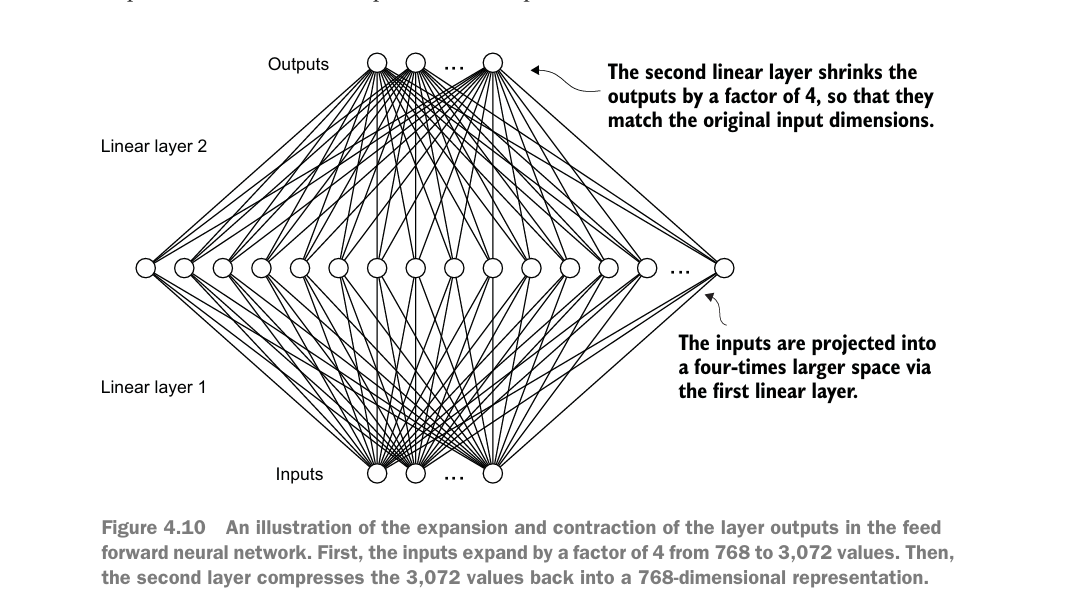

**<H1>Adding Shortcut connections</h1>**

skip or residual connections
Originally, shortcut connections were proposed for deep networks in
 computer vision (specifically, in residual networks) to mitigate the challenge of van
ishing gradients. The vanishing gradient problem refers to the issue where gradients
 (which guide weight updates during training) become progressively smaller as they
 propagate backward through the layers, making it difficult to effectively train earlier
 layers.

 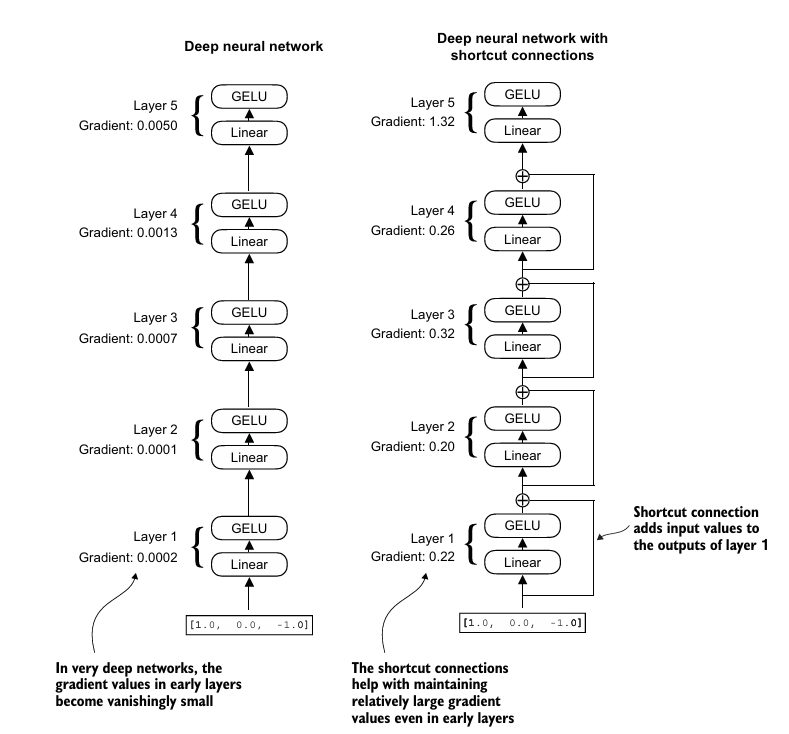

In [ ]:
#A network to illustrate shortcut connections

class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ]
    )

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

def print_gradients(model, x):
  output = model(x)
  target =  torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss= loss(output, target)

  loss.backward() #backward pass to calcuate gradients
  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")



In [ ]:
print_gradients(model_without_shortcut, sample_input)

#the output shows gradients become smaller as we move from last layer to first layer which is called vanishing gradient problem

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [ ]:
#now with skip connections

torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


**<h1>Connecting attention and linear layes in a transformer block</h1>**

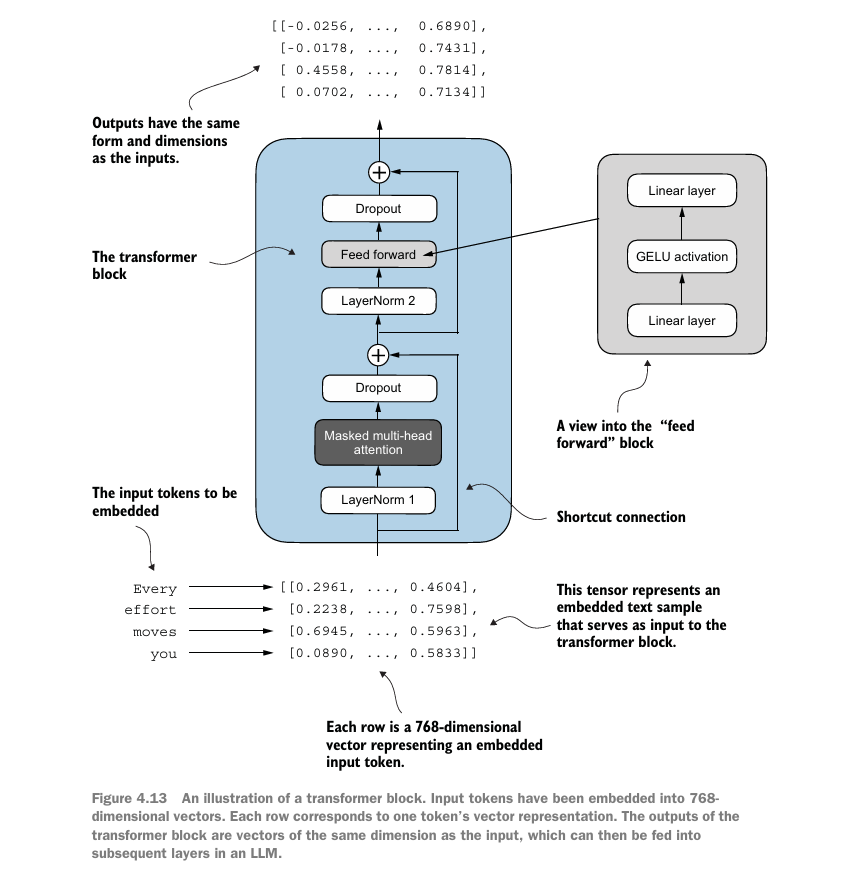

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert( d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out //num_heads
    self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_in, d_out)
    self.dropout= nn.Dropout(dropout)
    self.register_buffer(
       "mask",
       torch.triu(torch.ones(context_length, context_length), diagonal = 1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.w_key(x)
    queries = self.w_query(x)
    values = self.w_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    attn_scores.masked_fill_(mask_bool, -torch.inf)

    attn_weights = torch.softmax(attn_scores/keys.shape[-1] ** 0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1,2)
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

    context_vec =  self.out_proj(context_vec)
    return context_vec


In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x  = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x= self.drop_shortcut(x)
    x = x + shortcut
    return x

In [ ]:
#instantiate a transformer block and feeding it sample data

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape: ", x.shape)
print("Output shape: ",output.shape)

Input shape:  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])


**<h1>Coding a GPT model</h1>**

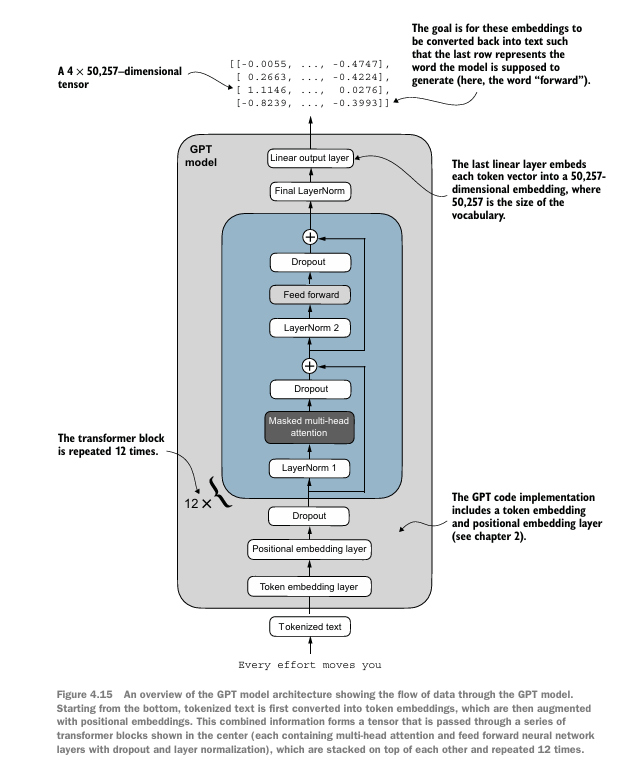

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch: \n", batch)
print("\n Output shape: ", out.shape)
print(out)

Input batch: 
 tensor([[6109, 3626, 3888,  345],
        [6109, 1110, 6622,  257]])

 Output shape:  torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.3187, -0.6270,  0.0955,  ..., -0.1462, -0.3503, -0.3174],
         [-1.0534,  0.1643, -0.1571,  ...,  0.7012,  0.3436, -0.1230]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
#finding the number of parameters in the model

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: ", total_params)

Total number of parameters:  163009536


In [ ]:
#parameter is more than 124million the key reason is weight lying
#Architecture reuses weights from token embeddings layer in its output layer

print("Token embedding layer shape: ", model.tok_emb.weight.shape)
print("Output Layer shape: ", model.out_head.weight.shape)

Token embedding layer shape:  torch.Size([50257, 768])
Output Layer shape:  torch.Size([50257, 768])


In [ ]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)

print(f"Number of trainable parameters after considering weight lying: {total_params_gpt2}")

Number of trainable parameters after considering weight lying: 124412160


In [ ]:
#memory requirements
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb: .2f}MB")


Total size of the model:  621.83MB


**<h1>Tensors to text Generating text</h1>**

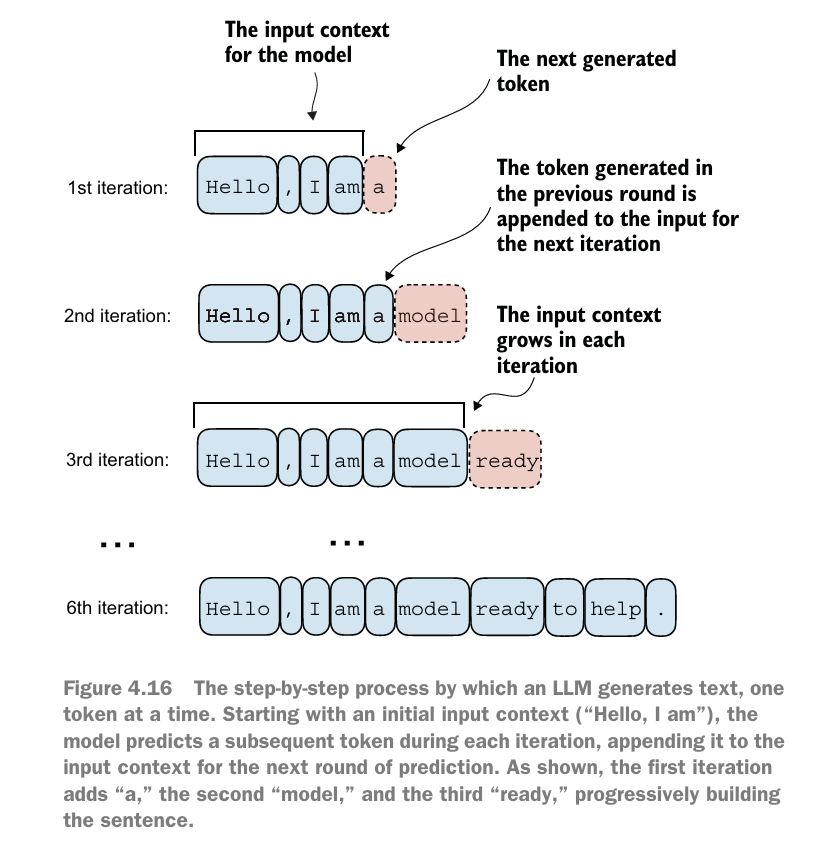


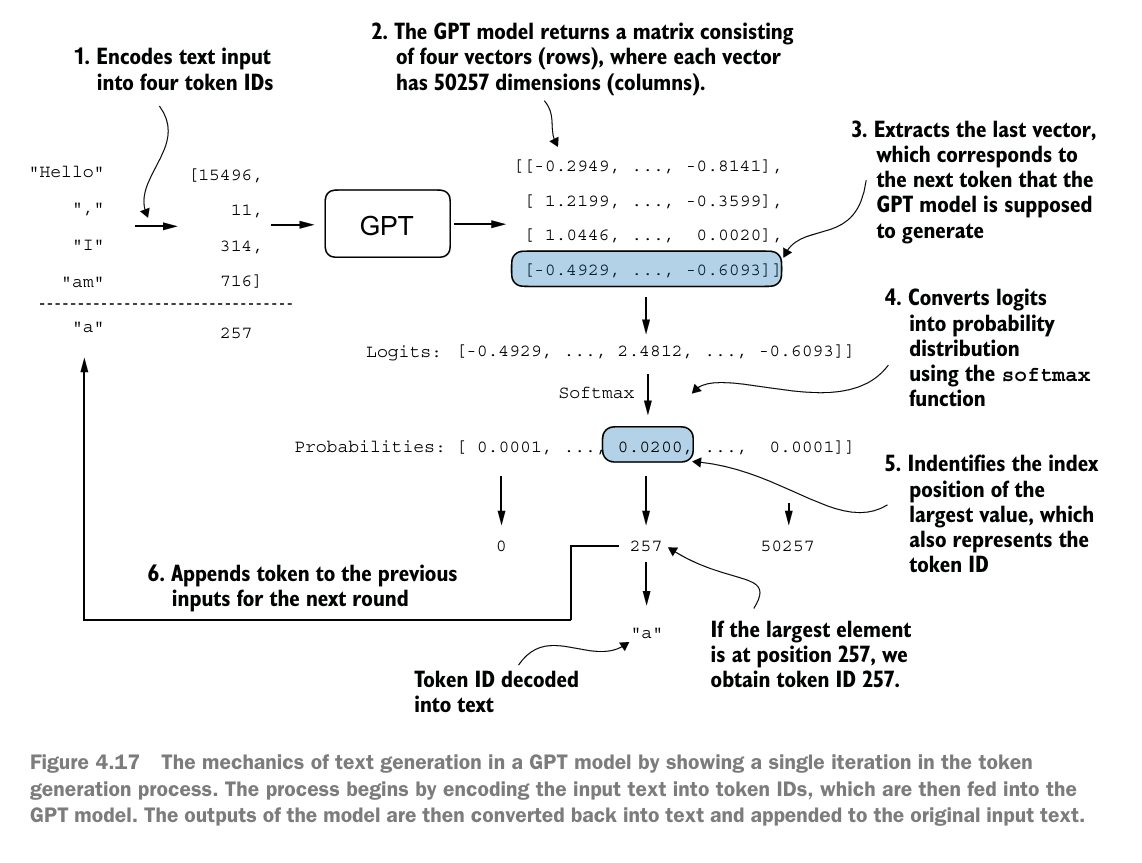

In [ ]:


def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim = 1)

  return idx

#using temprature scaling and top-k sampling to modify above function which will be done
#below

In [ ]:
start_context = "Hello, I "
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encode_tensor.shape: ", encoded_tensor.shape)

encoded:  [15496, 11, 314, 220]
encode_tensor.shape:  torch.Size([1, 4])


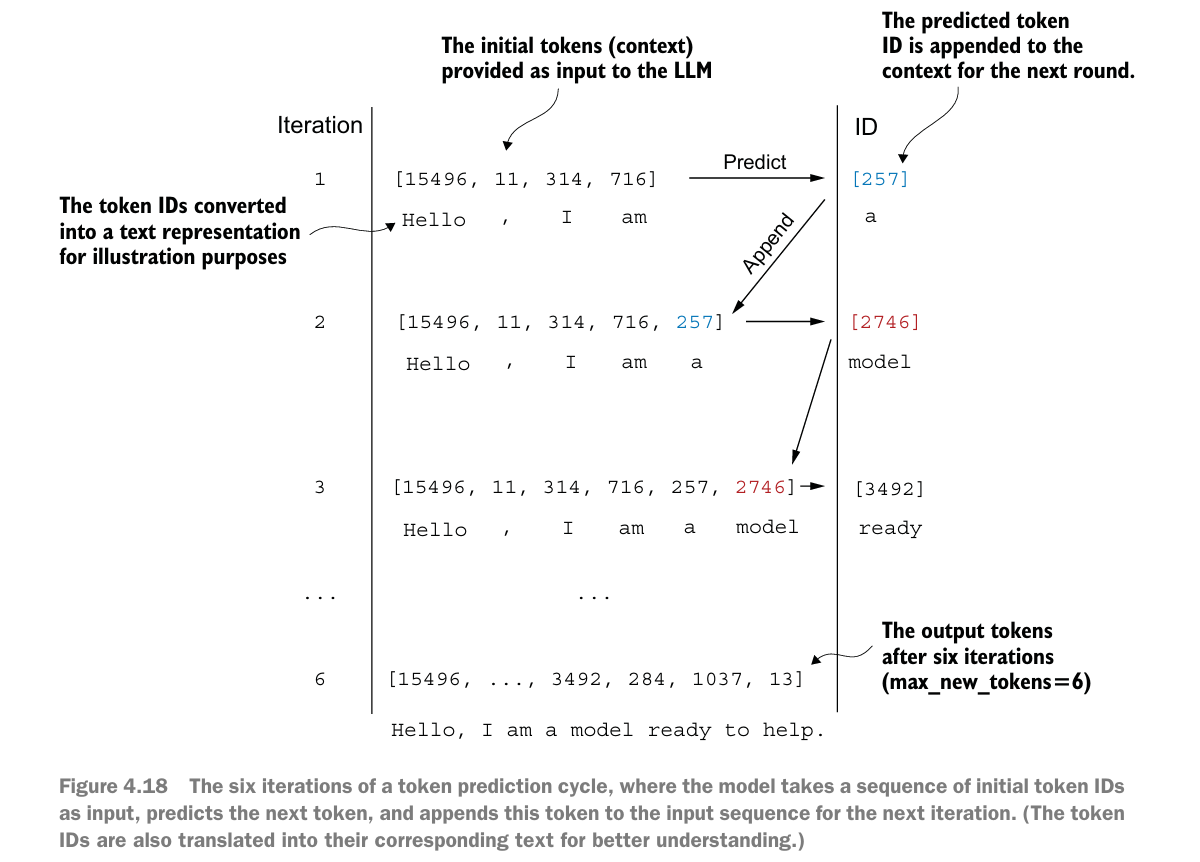

In [ ]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
print("Output length: ", len(out[0]))

NameError: name 'model' is not defined

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I arrayStudio Ch intest Magnetic destinations


In [ ]:
#checking different text
start_context = "I read in thapathali I am dead"
print ("Input text: ", start_context)
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encode_tensor.shape: ", encoded_tensor.shape)
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
print("Output length: ", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Output: ",decoded_text)

Input text:  I read in thapathali I am dead
encoded:  [40, 1100, 287, 294, 499, 776, 7344, 314, 716, 2636]
encode_tensor.shape:  torch.Size([1, 10])
Output:  tensor([[   40,  1100,   287,   294,   499,   776,  7344,   314,   716,  2636,
         36853,  6040, 11764, 32870,  1033,  6229, 23558, 31853,   371, 19853,
         41074,  4446,  8967, 26347, 32548]])
Output length:  25
Output:  I read in thapathali I am deadら scr openly fetish exp ment marched barric R MonsNJ voters disorder speeding revise


### **Pretraining chapter 5**


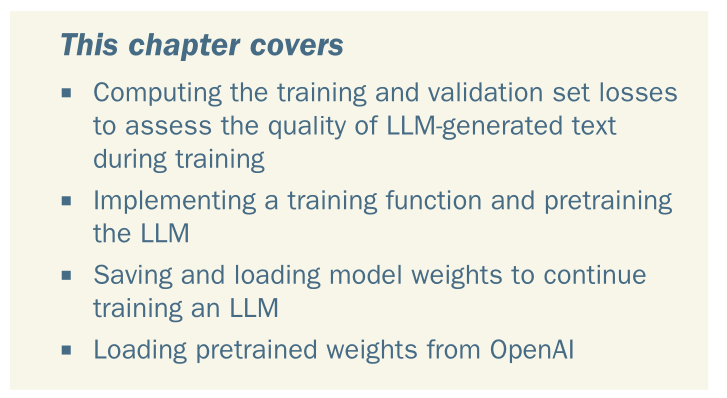


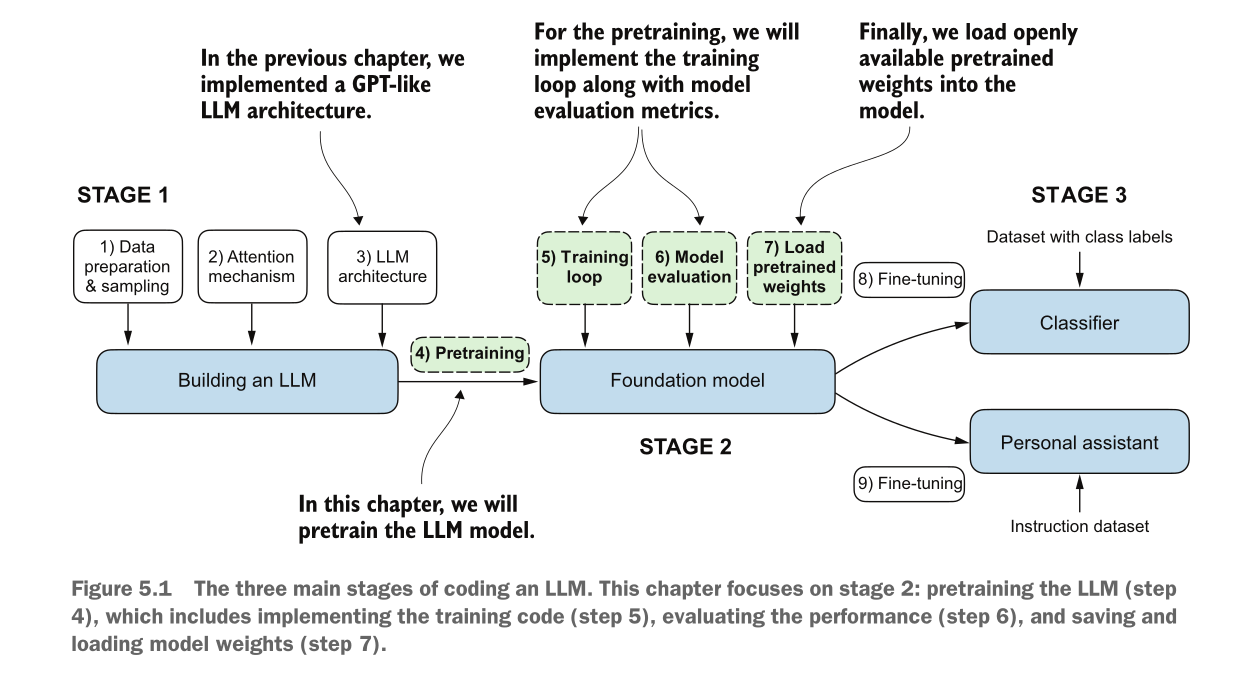



**<h1>Evaluating generative text models</h1>**

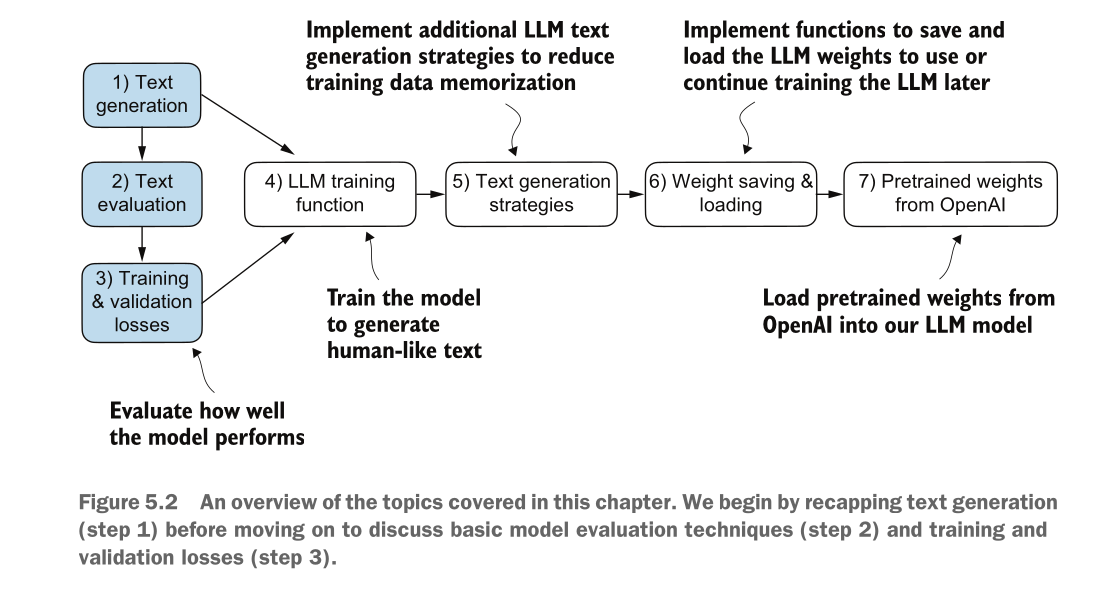

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, #shorten the context length
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
#decreased the context length to 256 to reduce computation demands of training
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features

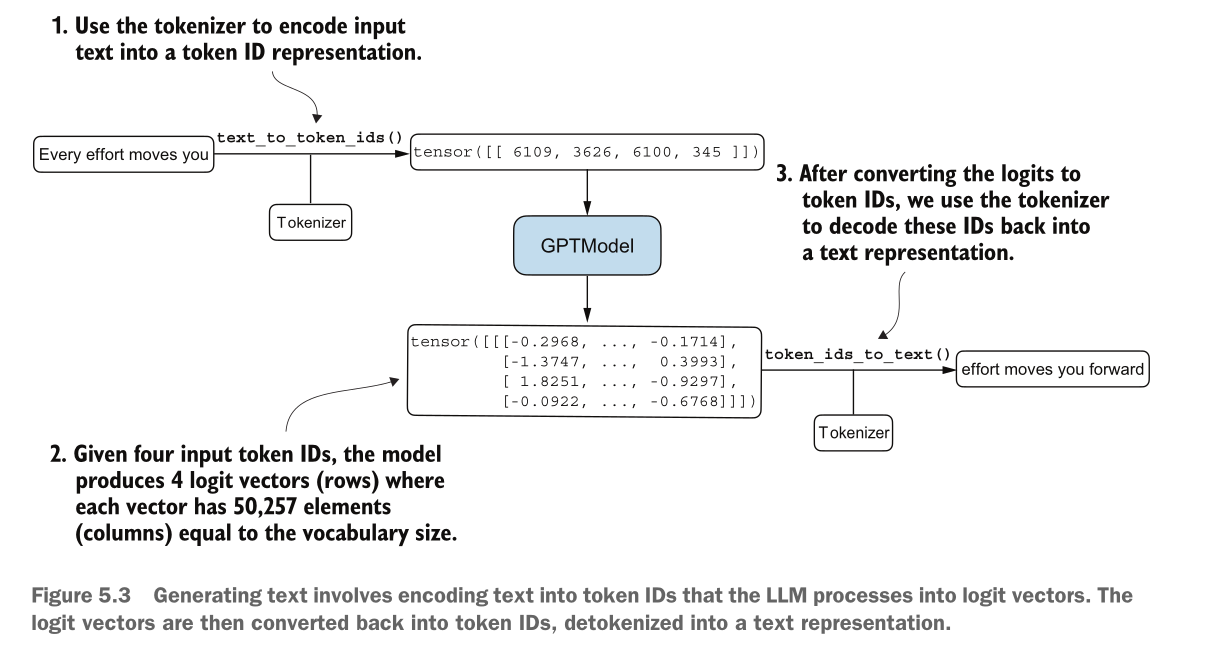

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) #adds a dimension at begining
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print('Output text: ', token_ids_to_text(token_ids, tokenizer))


Output text:  Every effort moves you rentingetic wasnم refres RexMeCHicular stren


**<h1>Calculating the text generation loss<h1>**

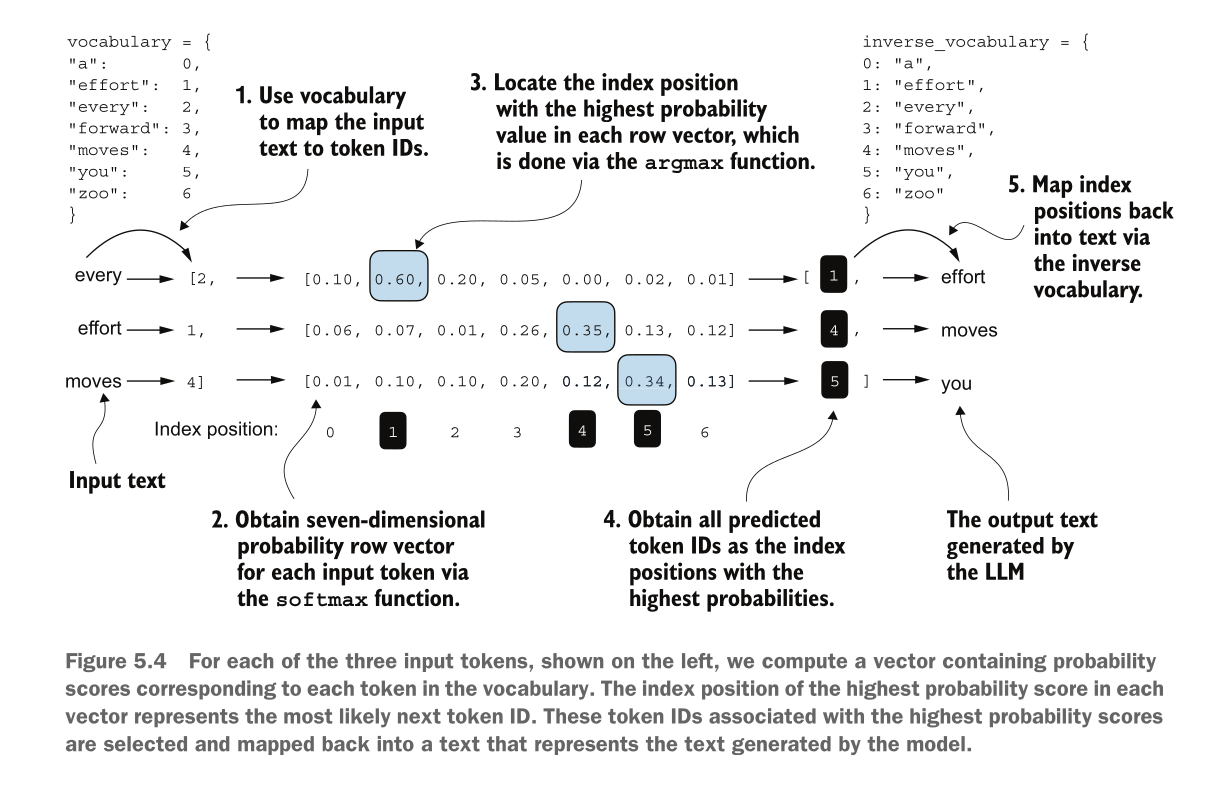

In [ ]:
#learning how text losses work with example

#inputs
torch.manual_seed(123)
inputs = torch.tensor([[16883, 3626, 6100],   # "every effort moves",
                       [40, 1107, 588]]) #"I really like"

#targets output
targets = torch.tensor([[3626, 6100, 345],  #"effort moves you"
                        [1107, 588, 11311]]) #"really like chocolate"

with torch.no_grad(): #disabls gradient tracking since we arenot training
  logits = model(inputs)
probas= torch.softmax(logits, dim=-1)
print(probas.shape)

token_ids = torch.argmax(probas, dim = -1, keepdim=True)
print("Token ids:\n", token_ids)


torch.Size([2, 3, 50257])
Token ids:
 tensor([[[16835],
         [16031],
         [21177]],

        [[49906],
         [29669],
         [41751]]])


In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

print(f"Targets batch 1: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 1:"f" {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Train saves Admir
Targets batch 1:  really like chocolate
Outputs batch 1:  pressuring empoweredfaith


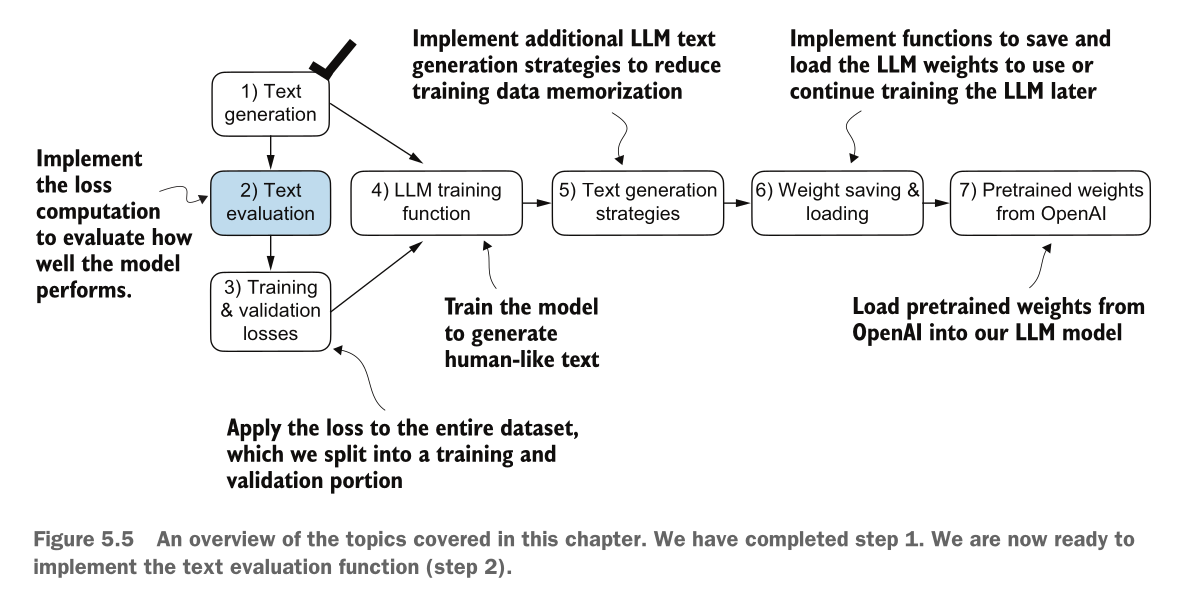

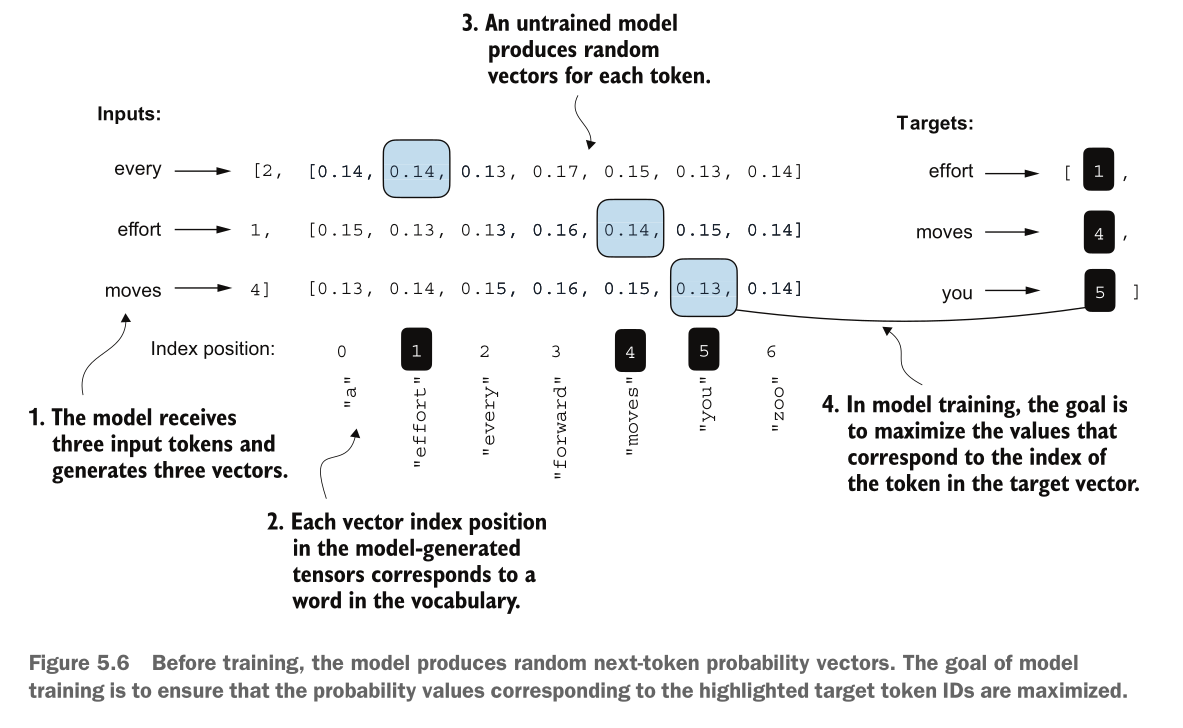

In [ ]:
torch.set_printoptions(sci_mode=True)

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([4.7821e-05, 2.8024e-05, 1.3866e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


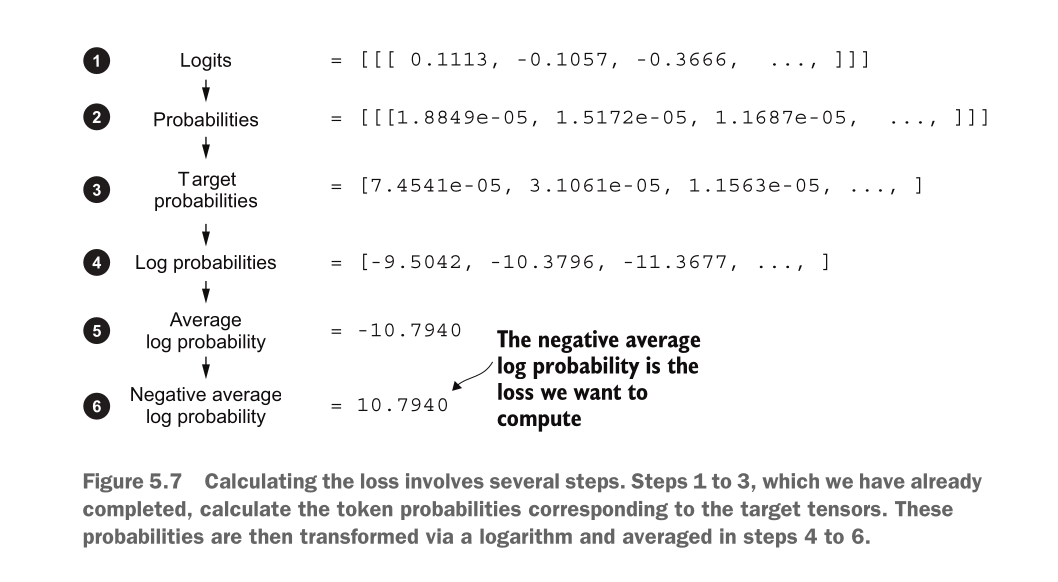

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

neg_avg_log_probas = avg_log_probas * 1


tensor([-9.9481e+00, -1.0482e+01, -1.1186e+01, -1.1480e+01, -9.7764e+00, -1.2256e+01])
tensor(-1.0855e+01)


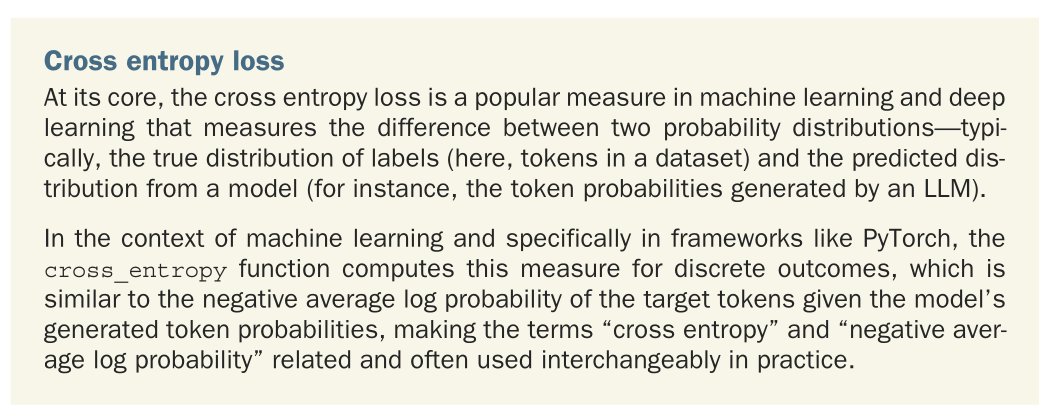

In [ ]:
print("logits shape: ", logits.shape)
print("Targets shape: ", targets.shape)

#for cross entropy loss function we want to flatten

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits: ", logits_flat.shape)
print("Flattened targtes: ", targets_flat.shape)

logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])
Flattened logits:  torch.Size([6, 50257])
Flattened targtes:  torch.Size([6])


In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(1.0855e+01)


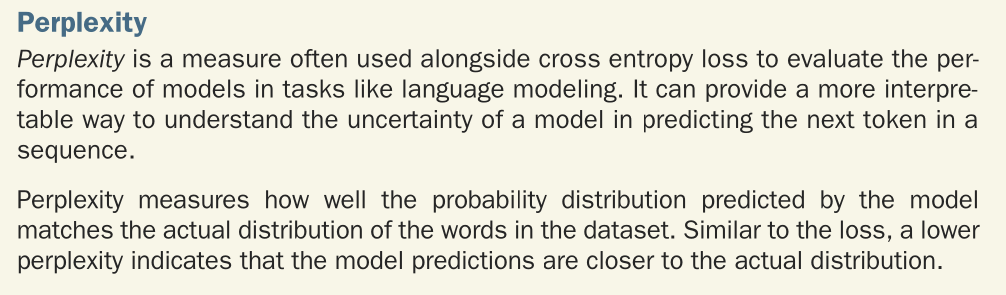

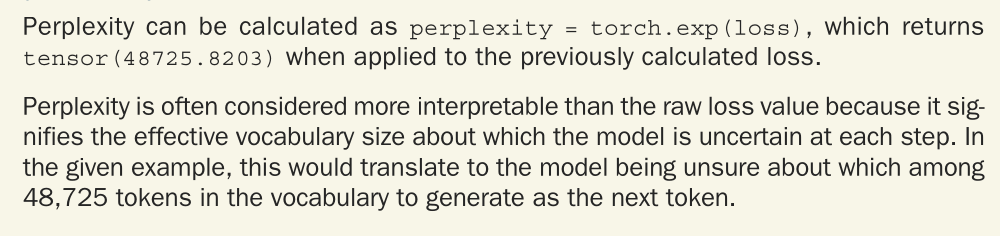

In [ ]:
perplexity  = torch.exp(loss)
print(perplexity)

tensor(5.1783e+04)


**<h1>Calculating the training and validation lset losses</h1>**

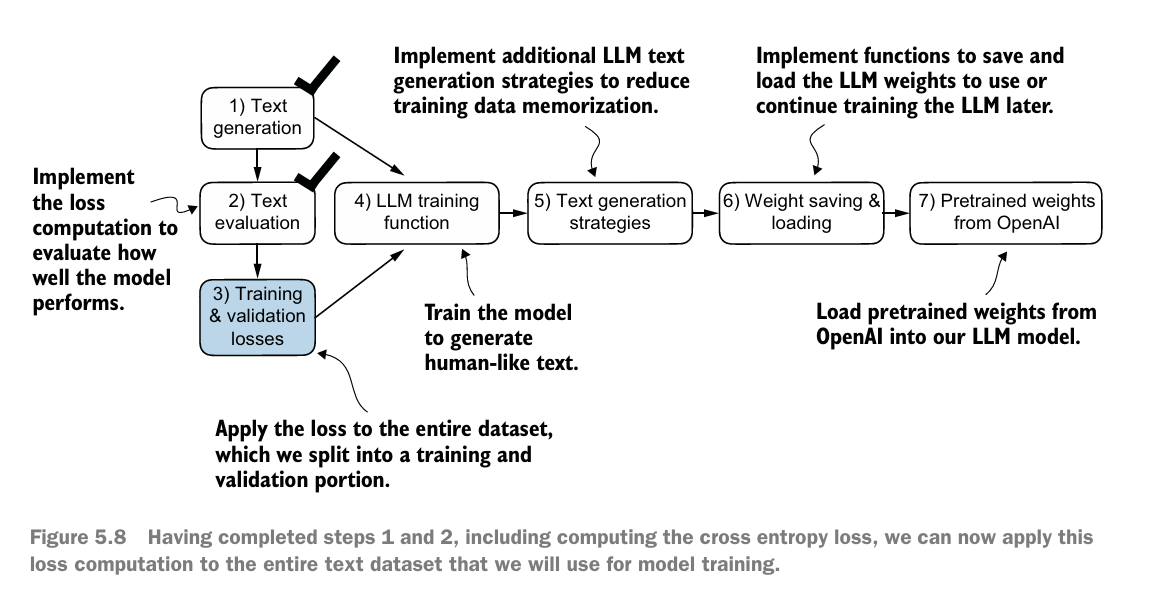


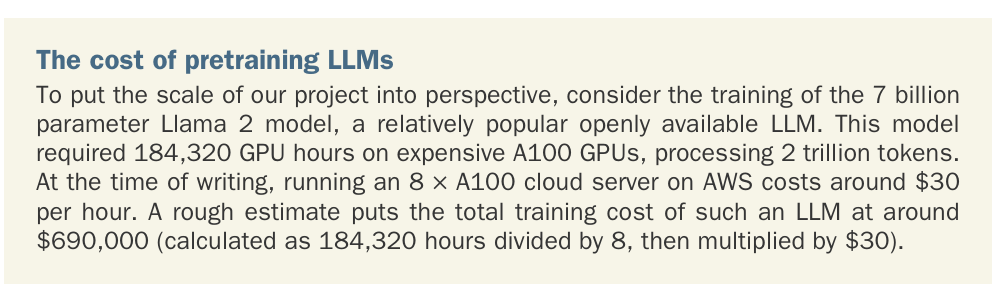

In [ ]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
  text_data = file.read()

print(text_data[0:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [ ]:
total_characters = len(text_data)
print(tokenizer.encode(text_data)[0:100])
total_tokens =  len(tokenizer.encode(text_data))
print('Characters: ', total_characters)
print("Tokens: ", total_tokens)

[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11, 290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536]
Characters:  20479
Tokens:  5145


**Loading a data**

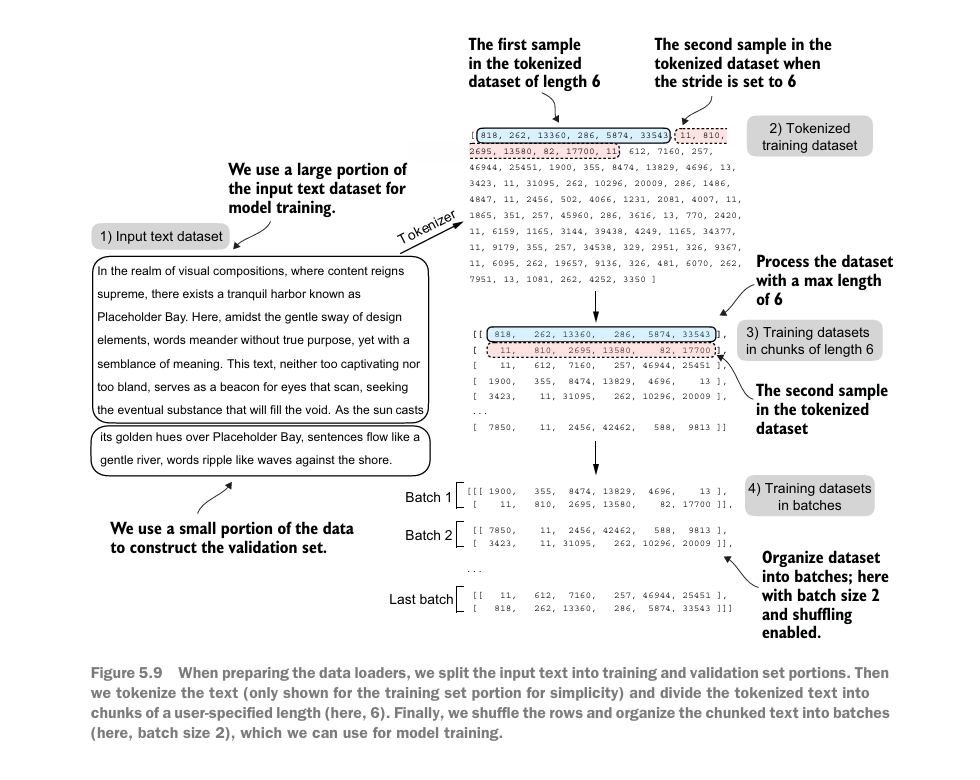

In [ ]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data [:split_idx]
print(len(train_data))
val_data  = text_data[split_idx:]
print(len(val_data))

18431
2048


In [ ]:
# part done in ch2

from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader



In [ ]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [ ]:
print("Train Loader")
for x,y in train_loader:
  print(x.shape, y.shape)

print("\nValidaiton loader")
for x,y in val_loader:
  print(x.shape, y.shape)

Train Loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validaiton loader
torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1), target_batch.flatten()
  )
  return loss

In [ ]:
# compute training and validation loss

def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches,len(data_loader))

  for i, (input_batch, target_batch) in enumerate (data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss/num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

Training loss:  10.987583584255642
Validation loss:  10.98110580444336


**<h1>Training an LLM</h1>**

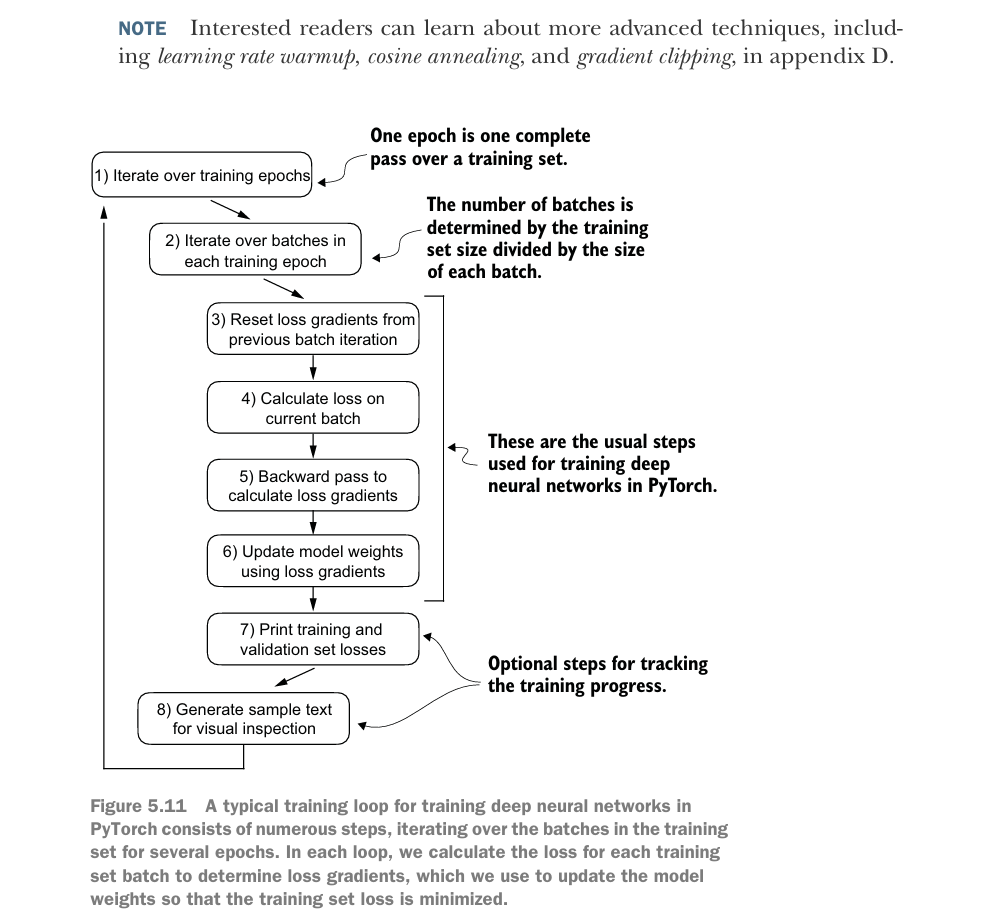

In [ ]:
#main function to pretrain LLM

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context,tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch + 1} (step {global_step:06d}): "
              f"Train loss {train_loss: .3f}, "
              f"Val loss {val_loss:.3f}")
  generate_and_print_sample(model, tokenizer, device, start_context)

  return train_losses, val_losses, track_tokens_seen



In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(    #mistakely I used generate_text_simple instead of sample
        model = model, idx= encoded,
        max_new_tokens = 50, context_size=context_size
    )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

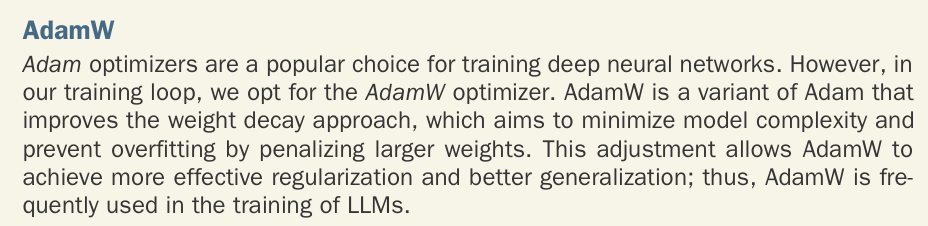

In [ ]:
#used for training check no need to use so commented
# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# model.to(device)
# optimizer = torch.optim.AdamW( model.parameters(), lr=0.0004, weight_decay=0.1)
# num_epochs = 10

# train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs= num_epochs,
#                                                            eval_freq = 5, eval_iter = 5, start_context="Every effort moves you", tokenizer=tokenizer)


In [ ]:
#this will be used once we train and used for visualization
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
#    fig, ax1 = plt.subplots(figsize=(5, 3))
#    ax1.plot(epochs_seen, train_losses, label="Training loss")
#    ax1.plot(
#       epochs_seen, val_losses, linestyle="-.", label="Validation loss"
#     )
#    ax1.set_xlabel("Epochs")
#    ax1.set_ylabel("Loss")
#    ax1.legend(loc="upper right")
#    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
#    ax2 = ax1.twiny()
#    ax2.plot(tokens_seen, train_losses, alpha=0)
#    ax2.set_xlabel("Tokens seen")
#    fig.tight_layout()
#    plt.show()

# epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
optimizer = torch.optim.AdamW( model.parameters(), lr=0.0004, weight_decay=0.1)

In [ ]:
#checking different text
start_context = "In the dimmest corner of her boudoir"
print ("Input text: ", start_context)
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encode_tensor.shape: ", encoded_tensor.shape)
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
print("Output length: ", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Output: ",decoded_text)

Input text:  In the dimmest corner of her boudoir
encoded:  [818, 262, 5391, 76, 395, 5228, 286, 607, 275, 2778, 10840]
encode_tensor.shape:  torch.Size([1, 11])
Output:  tensor([[  818,   262,  5391,    76,   395,  5228,   286,   607,   275,  2778,
         10840, 18748,  7236, 32544,  3543, 32581, 22799, 18955, 46195, 36658,
         25547,  5214, 21338, 46355, 16821, 16448]])
Output length:  26
Output:  In the dimmest corner of her boudoirilitary Never 238ocked sod-$ molecularč =================flower 37 grappzyk CantREL


## **5.3 Decoding strategies to control randomness**



In [ ]:
model.to("cpu")
model.eval

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M['context_length']
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))



Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren Mortgage TT remember gard ACTIONSussedOND Land Engeleddedemate breaths proxies GalaxyForm


##**5.3.1 Temperature scaling**
Temprature scaling is a technique that adds probabilistic selection process to next-token generation task.In generate _text_simple funtion we sampled the token with the highest probability *greedy decoding*.To generate text with more variety we replace argmax with function that samples from a probability distribution

- instead of using argmax function if we use multinominal function, the LLM will sometimes generate text which is different for same input say.
for eg : input = every effort moves you <br>
output next tokens = (forward, ahead, pizza,toward)<br>
in argmax lets suppose forward has highest logit (softmax), but if we use multinominal and given inputs lets say 100 times output may be different lets say

1) forward - 60, ahead-15, pizza - 0, toward 25

we can furthur control the distribution and selection process with temperature scaling

In [ ]:
#a example to show how multinominal works
vocab = {
    "closer": 0,
    "every" : 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}
#assume we give "every effort moves you" which generated the given next-token logits for above vocab
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

#to implement probabilistic sampling process, we can replace argmax with the multinomial function in pytorch

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])
#still forward is output which is most likely but not all the time

def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate (sampled_ids):
    print(f"{freq} =  {inverse_vocab[i]}")

print_sampled_tokens(probas)


forward
forward
73 =  closer
0 =  every
0 =  effort
582 =  forward
2 =  inches
0 =  moves
0 =  pizza
343 =  toward


to furthur control the distribution and selection process we use temperature scaling which is just dividing logits by value greater than 0. Temperatures greater than 1 result in more uniformly distributed token probabilities, and temperature smaller than 1 will result in more confident(sharper) distributions.

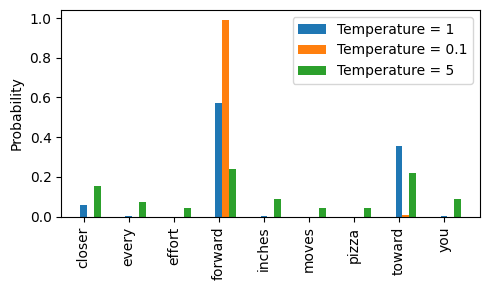

In [ ]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits/temperature
  return torch.softmax(scaled_logits, dim=0)
#plotting to see original propabilities along with temperature values

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits,T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize = (5,3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

##

##**5.3.2 Top-K sampling**
As we have seen using temperature scaling allowed for the exploring of less likely but  potentially more interesting paths. One downside of this approach is that it leads to gramatically incorrect or nonsense outputs such as "every effort moves you pizza"

Top-k sampling, when combined with probabiilistic sampling and temperature sampling can improve the text generation results. In Top-k sampling, we can restrict the sampled tokens to the most likely token and exclude all other tokens from the selection process  by masking their probability scores.
<br>
The top-k approach replaces all nonselected logits with negative infinite value

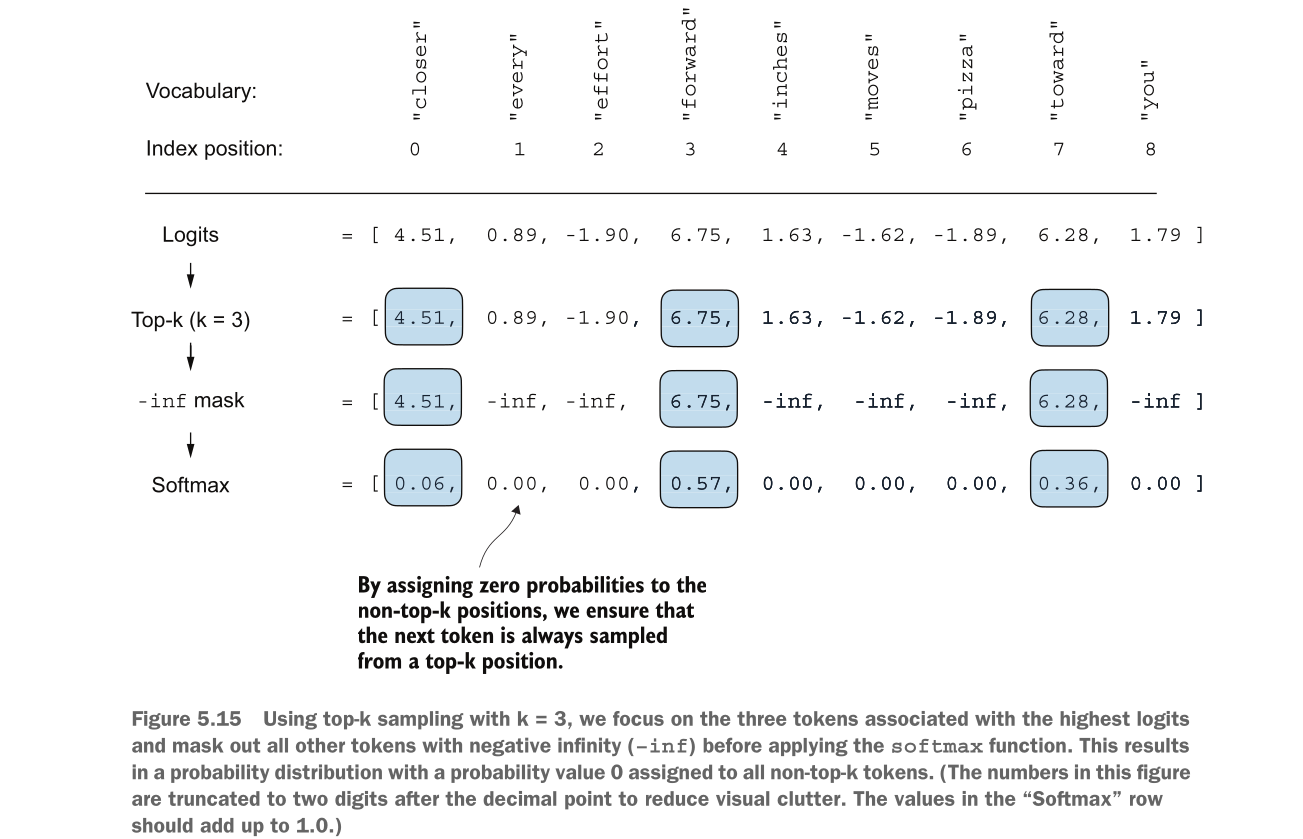

In [ ]:
#trying
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("top logits", top_logits)
print("top positions", top_pos)

new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other = next_token_logits
)
print(new_logits)
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

top logits tensor([6.7500e+00, 6.2800e+00, 4.5100e+00])
top positions tensor([3, 7, 0])
tensor([4.5100e+00,   -inf,   -inf, 6.7500e+00,   -inf,   -inf,   -inf, 6.2800e+00,   -inf])
tensor([6.1485e-02, 0.0000e+00, 0.0000e+00, 5.7755e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6097e-01, 0.0000e+00])


##**5.4 Loading and saving model weights in PyTorch**


dropout helps prevent the model from overfitting to the
training data by randomly “dropping out” of a layer’s neurons during training. How-
ever, during inference, we don’t want to randomly drop out any of the information
the network has learned. Using model.eval() switches the model to evaluation mode
for inference, disabling the dropout layers of the model. If we plan to continue pre-
training a model later—for example, using the train_model_simple function we
defined earlier in this chapter—saving the optimizer state is also recommended.
Adaptive optimizers such as AdamW store additional parameters for each model
weight. AdamW uses historical data to adjust learning rates for each model parameter
dynamically. Without it, the optimizer resets, and the model may learn suboptimally
or even fail to converge properly, which means it will lose the ability to generate coher-
ent text. Using torch.save, we can save both the model and optimizer state_dict
contents

In [ ]:
#save model's state_dict, a dictonary mapping each layer to its parameters
torch.save(model.state_dict(),"model.pth")

#load
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location = device))
model.eval()

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},"model_and_optimizer.pth")

#restore and load
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])


##**5.3.3 Modifying the text generation function**
combining temprature sampling and top-k sampling to modify the generate_text_simple function used to generate text

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx if idx.size(1) <= context_size else idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    if top_k is not None:
      # top_k returns (values, indices). We want the smallest value from the top-k values.
      # top_logits.values will have shape (batch_size, top_k).
      # We take the last element which is the smallest, and unsqueeze to (batch_size, 1) for broadcasting.
      top_logits_values, _ = torch.topk(logits, top_k)
      min_val = top_logits_values[:, -1].unsqueeze(-1) # Correctly get the minimum of the top-k values
      logits = torch.where(
          logits < min_val,
          torch.tensor(float("-inf")).to(logits.device),
          logits
      )
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples = 1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)
    if idx_next == eos_id:
      break
    idx = torch.cat((idx, idx_next), dim=1)
  return idx

In [ ]:
torch.manual_seed(123)
input_text = "Every effort moves you"
token_ids = generate(
    model= model,
    idx = text_to_token_ids(input_text, tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature = 1.4

)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you renting Beta Spell convendd 530ateg medal437veyard sortssdprotectedJr phosphate


##**5.5 Loading pretrained weights from OpenAI**

In [ ]:
pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import urllib.request
url = (
  "https://raw.githubusercontent.com/rasbt/"
  "LLMs-from-scratch/main/ch05/"
  "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7a1dfe8712e0>)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 174kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.52MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 182kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:30<00:00, 16.2MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 6.30MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.80MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.42MiB/s]


In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
#showed only the keys as printing weights would take too much space
print(params["wte"])
print("Token embedding weight tensor dimensions: ", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions:  (50257, 768)


In [ ]:
model_configs = {
  "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
  "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
  "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
  "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=7

In [ ]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape} ,Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [ ]:
#loading OpenAI weights into our GPT model code
import numpy as np
def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
      (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.w_query.weight = assign(
      gpt.trf_blocks[b].att.w_query.weight, q_w.T)
    gpt.trf_blocks[b].att.w_key.weight = assign(
      gpt.trf_blocks[b].att.w_key.weight, k_w.T)
    gpt.trf_blocks[b].att.w_value.weight = assign(
      gpt.trf_blocks[b].att.w_value.weight, v_w.T)
    q_b, k_b, v_b = np.split(
      (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.w_query.bias = assign(
      gpt.trf_blocks[b].att.w_query.bias, q_b)
    gpt.trf_blocks[b].att.w_key.bias = assign(
      gpt.trf_blocks[b].att.w_key.bias, k_b)
    gpt.trf_blocks[b].att.w_value.bias = assign(
      gpt.trf_blocks[b].att.w_value.bias, v_b)
    gpt.trf_blocks[b].att.out_proj.weight = assign(
      gpt.trf_blocks[b].att.out_proj.weight,
      params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(
      gpt.trf_blocks[b].att.out_proj.bias,
      params["blocks"][b]["attn"]["c_proj"]["b"])
    gpt.trf_blocks[b].ff.layers[0].weight = assign(
      gpt.trf_blocks[b].ff.layers[0].weight,
      params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(
      gpt.trf_blocks[b].ff.layers[0].bias,
      params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ff.layers[2].weight = assign(
      gpt.trf_blocks[b].ff.layers[2].weight,
      params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(
      gpt.trf_blocks[b].ff.layers[2].bias,
      params["blocks"][b]["mlp"]["c_proj"]["b"])
    gpt.trf_blocks[b].norm1.scale = assign(
      gpt.trf_blocks[b].norm1.scale,
      params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
      gpt.trf_blocks[b].norm1.shift,
      params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
      gpt.trf_blocks[b].norm2.scale,
      params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
      gpt.trf_blocks[b].norm2.shift,
      params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=7

In [ ]:
torch.manual_seed(123)
input_text = "Im tired trying to train you"
token_ids = generate(
    model= gpt,
    idx = text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=50,
    temperature = 1.5

)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Im tired trying to train you not to write down what you actually want to write? The more complicated things can be, because if two things don't happen


In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},"gptmodel.pth")

In [ ]:
import urllib.request

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam-collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction")
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")


download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [ ]:
import pandas as pd
df = pd.read_csv(data_file_path, sep= "\t", header = None, names = ["Label", "Text"])
df.head(5)

Label                                               Text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [ ]:
df["Label"].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [ ]:
#just undersampling as its easier to train and removing class imbalance
def create_balanced_dataset(df):
  num_spam = df[df["Label"] == "spam"].shape[0]
  ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state = 123)
  balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})

In [ ]:
def random_split(df, train_frac, validation_frac):
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]
  return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)


In [ ]:
train_df.to_csv("train.csv", index = None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index = None)


In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))


[50256]


In [ ]:
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length= None, pad_token_id = 50256):
    self.data = pd.read_csv(csv_file)

    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]

  def __getitem__(self, index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length > max_length:
        max_length = encoded_length
    return max_length




In [ ]:
train_dataset = SpamDataset(
    csv_file = "train.csv",
    max_length = None,
    tokenizer = tokenizer
)

In [ ]:
print(train_dataset.max_length)

120


In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer = tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)


In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)




In [ ]:
for input_batch, target_batch in train_loader:
  pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


In [ ]:
BASE_CONFIG = {
    "vocab_size" : 50257,
    "context_length" :1024,
    "drop_rate":0.0,
    "qkv_bias":False,
    "emb_dim":768
}

model_configs = {
  "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
  "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
  "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
  "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


In [ ]:
input_text = "Every effort moves you forward"
token_ids = generate(
    model= gpt,
    idx = text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance


In [ ]:
text_2 = (
    "is the following text 'spam'? Answer with 'yes' or 'no':"
    "'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))


is the following text 'spam'? Answer with 'yes' or 'no':'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' subject tripodв DateIndeed saint collectorsslave Yourself optimal helpgive continued Cyborg ≤ peakedinson Wikimediacell wonder/. Disco drivers


In [ ]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features

In [ ]:
for param in model.parameters():
  param.requires_grad = False

torch.manual_seed(123)
num_classes = 2
model.out_head=torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True
for param in model.final_norm.parameters():
  param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)
with torch.no_grad():
  outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[6.3858e-03, -2.8871e-01],
         [-2.9632e-01, 3.0995e-01],
         [1.0490e-02, -3.9206e-01],
         [3.1985e-01, -1.8740e-02]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[3.1985e-01, -1.8740e-02]])


In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("class label:", label.item())

class label: 0


In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 0


In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)

  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate (data_loader):
    if i < num_batches:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :]
      predicted_labels = torch.argmax(logits, dim = -1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (
          (predicted_labels == target_batch).sum().item()
      )

    else:
      break
    return correct_predictions/num_examples

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
  train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
  val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
  test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 75.00%
Validation accuracy: 50.00%
Test accuracy: 37.50%


In [ ]:
def   (input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i  < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss/num_batches

In [ ]:
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
  test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.815
Validation loss: 0.789
Test loss: 0.837


In [ ]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
  train_losses, val_losses, train_accs, val_accs = [],[],[],[]
  examples_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep{epoch+1} step {global_step: 06d} \n Train loss {train_loss: .3f} \n val_loss {val_loss:.3f}")

      train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
      val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
      print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
      print(f"Validation accuracy: {val_accuracy*100:.2f}%")
      train_accs.append(train_accuracy)
      val_accs.append(val_accuracy)

  return train_losses, val_losses, train_accs, val_accs, examples_seen


In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen =train_classifier_simple(
  model, train_loader, val_loader, optimizer, device,
  num_epochs=num_epochs, eval_freq=50,
  eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep1 step  00000 
 Train loss  1.011 
 val_loss 0.855
Training accuracy: 50.00% | Validation accuracy: 50.00%
Training accuracy: 62.50% | Validation accuracy: 50.00%
Training accuracy: 62.50% | Validation accuracy: 75.00%
Training accuracy: 62.50% | Validation accuracy: 75.00%
Training accuracy: 50.00% | Validation accuracy: 62.50%
Training accuracy: 75.00% | Validation accuracy: 75.00%
Training accuracy: 75.00% | Validation accuracy: 87.50%
Training accuracy: 75.00% | Validation accuracy: 87.50%
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training accuracy: 75.00% | Validation accuracy: 100.00%
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training accuracy: 87.50% | Validation accuracy: 100.00%
Training accuracy: 75.00% | Validation accuracy: 100.00%
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training accuracy: 100.00% | Validation accuracy: 87.50%
Training accuracy: 100.00% | Validation accuracy: 87.50%
Training accuracy: 100.00% | Validation 

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},"classificationtask.pth")

ValueError: x and y must have same first dimension, but have shapes (1,) and (13,)

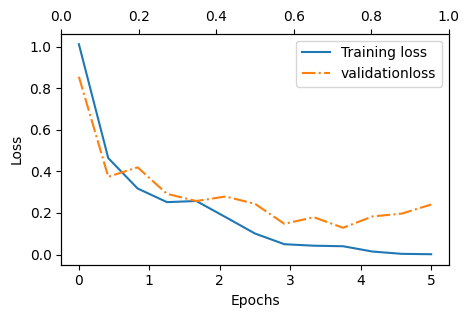

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, example_seen, train_values, val_values, label='loss'):
  fig, ax1 = plt.subplots(figsize=(5,3))

  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(epochs_seen, val_values,linestyle="-.", label=f"validation{label}")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")
  fig.tight_layout()
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

ValueError: x and y must have same first dimension, but have shapes (1,) and (650,)

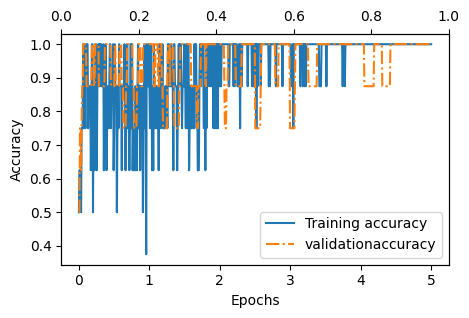

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs,label="accuracy")



In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 87.50%


In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
  model.eval()
  input_ids = tokenizer.encode(text)
  supported_context_length = model.pos_emb.weight.shape[1]

  input_ids = input_ids[:min(max_length, supported_context_length)]
  input_ids +=[pad_token_id] * (max_length - len(input_ids))

  input_tensor = torch.tensor(input_ids, device = device).unsqueeze(0)
  with torch.no_grad():
    logits = model(input_tensor)[:, -1, :]
  predicted_label = torch.argmax(logits, dim=-1).item()

  return "spam" if predicted_label == 1 else "not spam"

In [ ]:
text_1 = ("Congratulations you are free winner of out lot")
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

text_2 = ("Hey, just wanted to check if we're still on for dinner tonight? Let me know!")
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam
not spam
